In [1]:
from os import listdir
from os.path import exists, join
import json

DATA_PATH = "../data"
OUTPUT_PATH = "../output"
EXPERIMENT = "CrossValidationTraining"
DATASETS= ["Deco", "FusTe"]


refined_data = {}
for dataset in DATASETS:
    refined_file_path = join(DATA_PATH, dataset, "refined.json")
    with open(refined_file_path) as f:
        refined_data[dataset] = json.load(f)
        
annotation_data = {}
for dataset in DATASETS:
    annotations_file_path = join(DATA_PATH, dataset, "annotations_elements.json")
    with open(annotations_file_path) as f:
        annotation_data[dataset] = json.load(f)

preprocessed_annotation_data = {}
for dataset in DATASETS:
    annotations_file_path = join(DATA_PATH, dataset, "preprocessed_annotations_elements.json")
    with open(annotations_file_path) as f:
        preprocessed_annotation_data[dataset] = json.load(f)

def is_multi_key(key, dataset):
    try:
        return refined_data[dataset][key]["table_count"] > 2
    except KeyError:
        tables = [region for region in annotation_data[dataset][key]["regions"] if region["region_type"] == "Table"]
        return len(tables) > 2

def get_edge_count(key, dataset):
    return refined_data[dataset][key]["edge_count"]

def file_accuracies(experiment_path):
    """Returns the file accuracies for this experiment"""
    file_accuracies = {}
    for fold_num in range(10):
        accuracy_file_path = join(
            experiment_path,   
            f"fold_{fold_num}",
            f"fold_{fold_num}_file_accuracies.json",
        )

        if not exists(accuracy_file_path):
            # Fold was aborted
            continue
        with open(accuracy_file_path) as f:
            fold_file_accuracies = json.load(f)["fold_file_accuracies"]
            for key, accuracy in fold_file_accuracies.items():
                file_accuracies[key] = accuracy
    return file_accuracies

def has_noise(experiment_path):
    config_file_path = join(
            experiment_path,   
            "config.json",
        )
    with open(config_file_path) as f:
        noise = json.load(f)["noise"]
    return bool(noise)

def get_experiment_paths(
    dataset,
    noise,
    improved=False,
    improvement_type="density",
):
    if improved and improvement_type not in ["density", "avg cut"]:
        raise ValueError("Unkown improvement type")
        
    exp_name = ("Improved" if improved else "") + EXPERIMENT
    d = join(OUTPUT_PATH, dataset, exp_name)
    experiments = listdir(d)
    experiment_paths = [
        join(d, exp)
        for exp in experiments
        if has_noise(join(d, exp)) == noise
    ]
    
    if not improved:
        return experiment_paths
        
    filtered_experiment_paths = []
    for p in experiment_paths:
        fold_0 = join(p, "fold_0", "fold_0_weights.json")
        with open(fold_0) as f:
            weight_length = len(json.load(f)["weights"])
        
        if weight_length == 12 and improvement_type == "density":
            filtered_experiment_paths.append(p)
        elif weight_length == 11 and improvement_type == "avg cut":
            filtered_experiment_paths.append(p)

    return filtered_experiment_paths

In [2]:
metrics = [
    "ndar",
    "nhar",
    "dp",
    "hp",
    "ioc",
    "ovh",
    "dahr",
    "avg_waec",
    "avg_waer",
    "ovr",
]
density_improved = [
    "single density",
    "multi density",
]
degree_improved = [
    "degree cut"
]

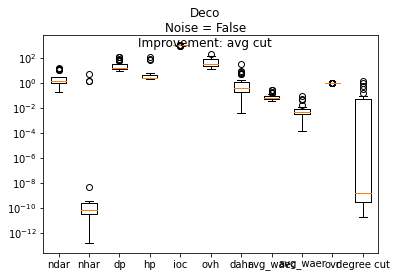

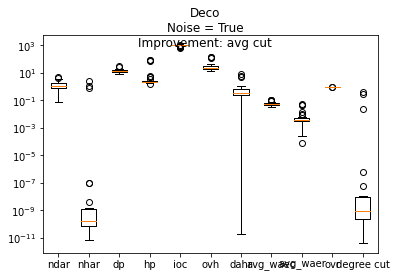

In [19]:
from pprint import pprint
import matplotlib.pyplot as plt


improvement = "avg cut"

effective_metrics = metrics[:]
improve = False

if improvement == "density":
    improve = True
    effective_metrics.extend(density_improved)
if improvement == "avg cut":
    improve = True
    effective_metrics.extend(degree_improved)
    

for dataset in ["Deco"]:
    for noise in [False, True]:
        experiment_weights = []
        for experiment in get_experiment_paths(dataset, noise, improve, improvement):
            for fold_num in range(10):
                fold_weight_file = join(experiment, f"fold_{fold_num}", f"fold_{fold_num}_weights.json")
                
                with open(fold_weight_file) as f:
                    fold_weights = json.load(f)["weights"]
                experiment_weights.append(fold_weights)
        
        experiment_weights = list(zip(*experiment_weights))
        plt.boxplot(experiment_weights, labels=effective_metrics)
        plt.yscale("log")
        plt.suptitle(f"{dataset}\nNoise = {noise}\nImprovement: {improvement}")
        plt.show()

In [18]:
get_experiment_paths("FusTe", True, True, "density")

['../output/FusTe/ImprovedCrossValidationTraining/noise_2_50a00664e3d311eb8689a9671f801994',
 '../output/FusTe/ImprovedCrossValidationTraining/noise_1_509fba10e3d311eb8688a9671f801994',
 '../output/FusTe/ImprovedCrossValidationTraining/noise_2_bc825d46e18f11eb8687a9671f801994',
 '../output/FusTe/ImprovedCrossValidationTraining/noise_1_bc818592e18f11eb8687a9671f801994',
 '../output/FusTe/ImprovedCrossValidationTraining/noise_3_bc827a4ce18f11eb8687a9671f801994',
 '../output/FusTe/ImprovedCrossValidationTraining/noise_3_509fa070e3d311eb8688a9671f801994']